# MNIST Analysis Project
Written paper to follow

__Credits__<br>
Jonathan Weisberg: https://jonathanweisberg.org/

In [1]:
import os, time, multiprocessing
import datetime as dt
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import offsetbox

from sklearn import svm, metrics
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.datasets import fetch_mldata

import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.optimizers import RMSprop, Adadelta

import warnings
warnings.filterwarnings('ignore')

Using TensorFlow backend.


## 1) Unsupervised Learning 

(a) Perform a principle component analysis on the MNIST data set. Produce various plots in the dimensionally reduced space using the principle components.

In [59]:
# Split data between train and test sets
(X_train, y_train), (X_test, y_test) = mnist.load_data()

X_train = X_train.reshape(60000, 784)
X_test = X_test.reshape(10000, 784)
train_images = X_train.astype('float32')
test_images = X_test.astype('float32')
train_images /= 255
test_images /= 255
train_labels = y_train
test_labels = y_test

In [60]:
# Fit PCA
pca = PCA()
train_pca = pca.fit_transform(train_images)
test_pca = pca.transform(test_images)

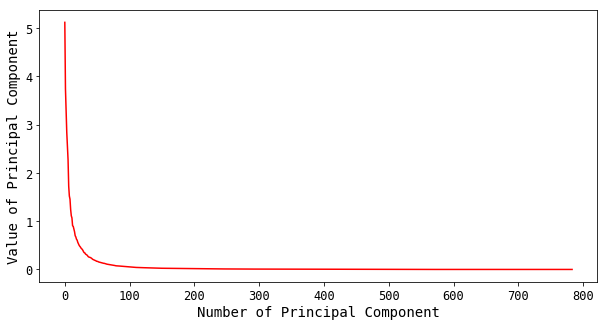

In [61]:
font = {'family' : 'monospace',
        'weight' : 'normal',
        'size'   : 12}

plt.rc('font', **font)

f, ax = plt.subplots(figsize = (10, 5))

plt.plot(pca.explained_variance_, c='r')
plt.xlabel('Number of Principal Component', fontsize=14)
plt.ylabel('Value of Principal Component', fontsize=14)
# plt.savefig("mnist_pca_var.png")
plt.show()

In [62]:
ev_ratio = pd.DataFrame(pca.explained_variance_ratio_)
tot = sum(pca.explained_variance_)
var_exp = [(i/tot)*100 for i in sorted(pca.explained_variance_, reverse=True)] 
cum_var_exp = np.cumsum(var_exp)

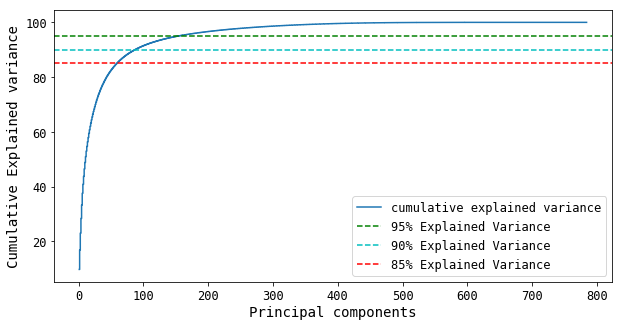

In [63]:
plt.figure(figsize=(10, 5))
plt.step(range(1, 785), cum_var_exp, where='mid',label='cumulative explained variance')
# plt.title('Cumulative Explained Variance as a Function of the Number of Components')
plt.ylabel('Cumulative Explained variance', fontsize=14)
plt.xlabel('Principal components', fontsize=14)
plt.axhline(y = 95, color='g', linestyle='--', label = '95% Explained Variance')
plt.axhline(y = 90, color='c', linestyle='--', label = '90% Explained Variance')
plt.axhline(y = 85, color='r', linestyle='--', label = '85% Explained Variance')
plt.legend(loc='best')
# plt.savefig("mnist_pca_cumvar.png")
plt.show()

<function matplotlib.pyplot.show(*args, **kw)>

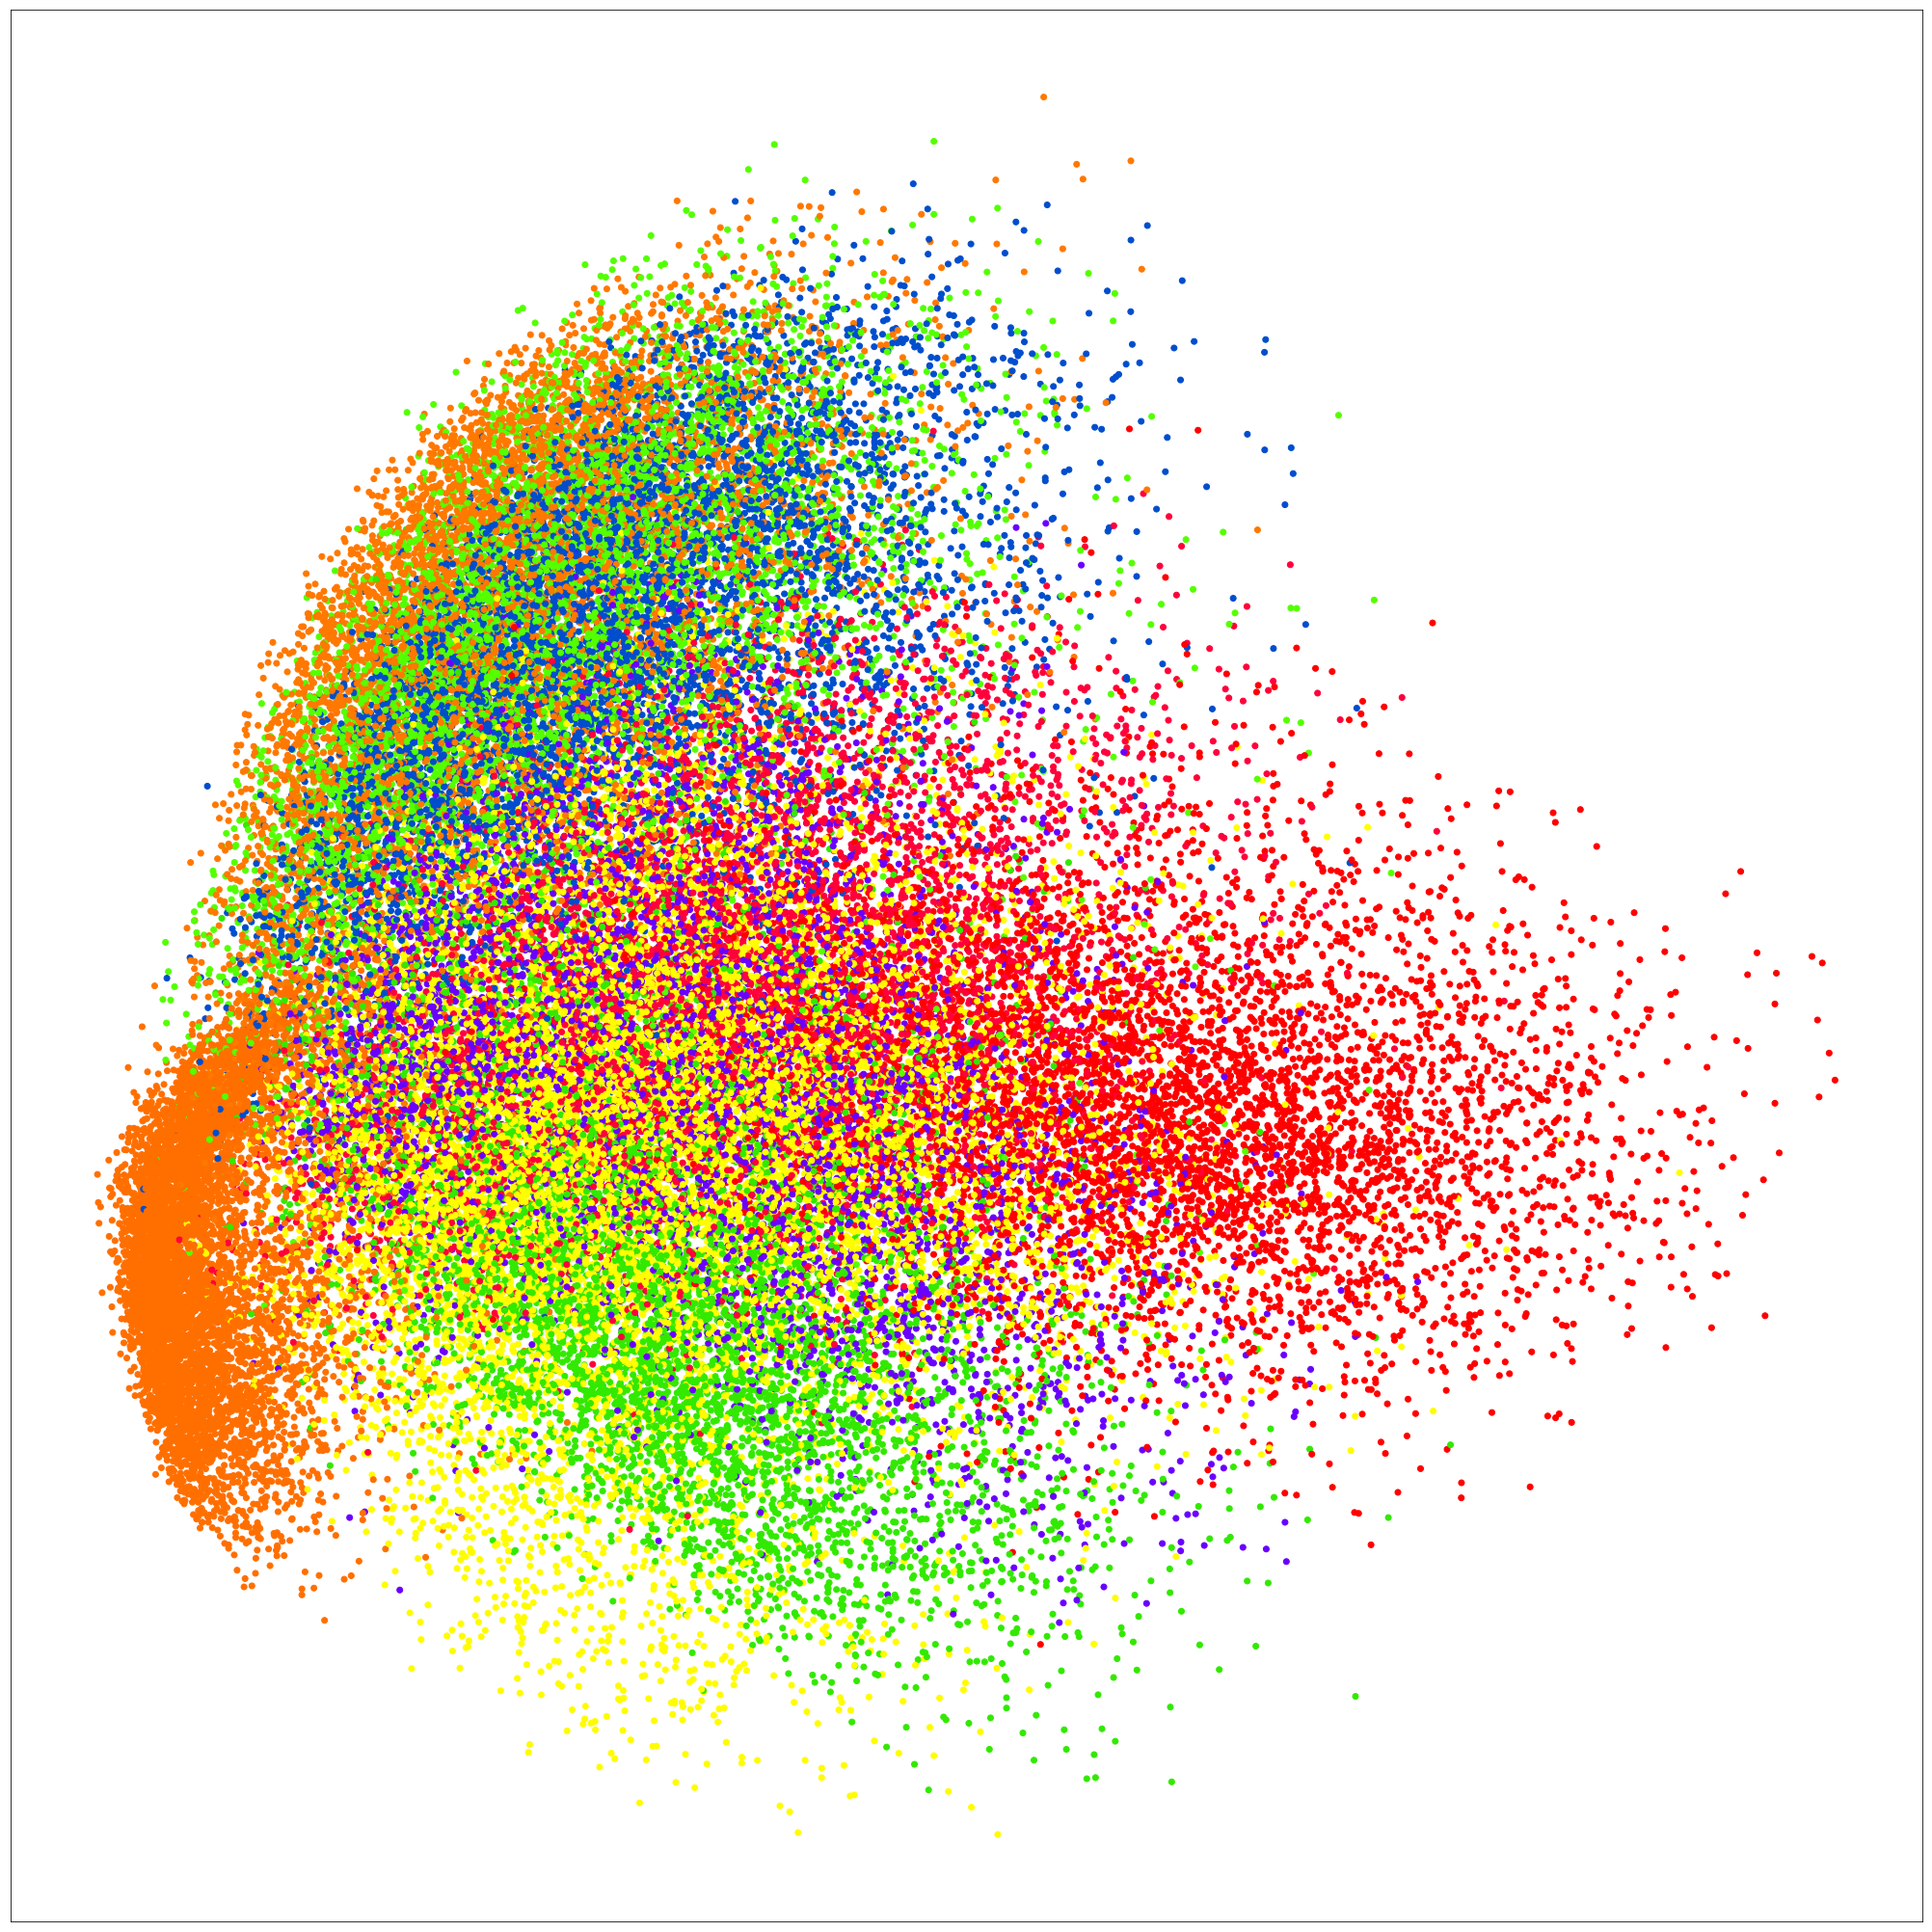

In [64]:
# Projecting the images using the principal component in a dimentionally reduced space
# This can be done using the two plotting code below. One provides a plot of all the numbers in a prism spectrum

# Prism Projection
fig, plot = plt.subplots()
fig.set_size_inches(28, 28)
plt.prism()

plot.scatter(train_pca[:, 0], train_pca[:, 1], c=train_labels)
plot.set_xticks(())
plot.set_yticks(())
plt.tight_layout()
# plt.savefig("mnist_pca_prism.png")
plt.show

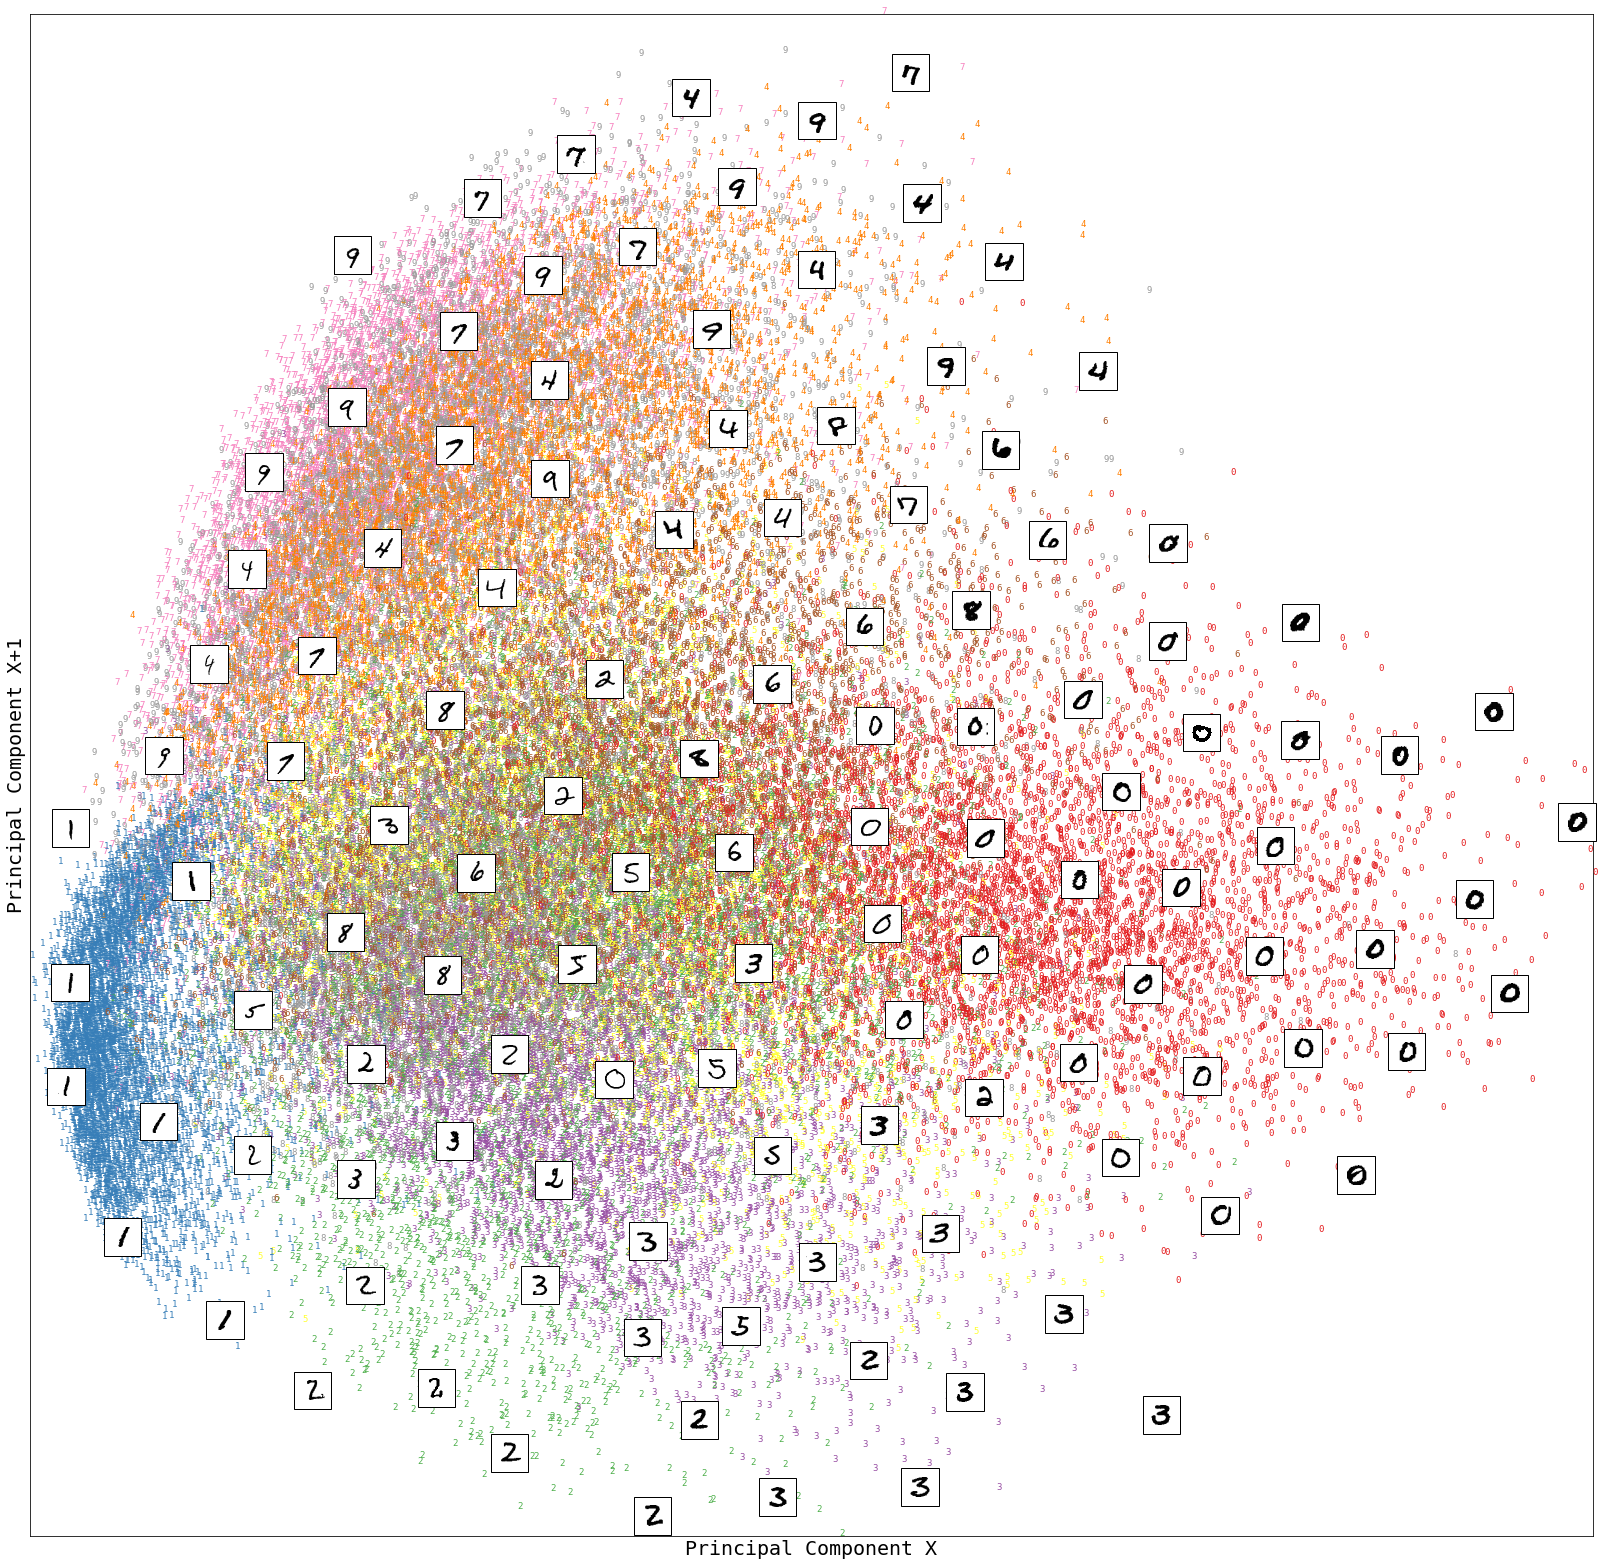

In [8]:
# The second is a defined function that plots the digits in the reduced space and the images plotted in that region

# Embeddings Projection
def emPlot(X, title=None):
    # Scaling plots to make visualisation easier
    x_min, x_max = np.min(X, 0), np.max(X, 0)
    X = (X - x_min) / (x_max - x_min)
    
    # Setting plot details 
    fig = plt.figure(figsize=(28,28))
    ax = fig.add_subplot(1, 1, 1)
    
    # Plotting the embeddings     
    for i in range(60000):
        plt.text(X[i, 0], X[i, 1], str(train_labels[i]),
                 color=plt.cm.Set1(train_labels[i]),
                 fontdict={'family': 'monospace', 'size': 9})
        
    # Only print thumbnails with matplotlib > 1.0 
    if hasattr(offsetbox, 'AnnotationBbox'):
        shown_images = np.array([[1., 1.]]) 
        for i in range(60000):
            dist = np.sum((X[i] - shown_images) ** 2, 1)
            
            # Exclude plots/points that are too close
            if np.min(dist) < 4e-3:
                continue
            shown_images = np.r_[shown_images, [X[i]]]
            imagebox = offsetbox.AnnotationBbox(
                offsetbox.OffsetImage(np.reshape(train_images[i],(28,28)), cmap=plt.cm.gray_r),
                X[i])
            ax.add_artist(imagebox)
    plt.xticks([]), plt.yticks([])
    plt.xlabel('Principal Component X', fontsize=20)
    plt.ylabel('Principal Component X+1', fontsize=20)
    #plt.savefig("mnist_pca.png")
    plt.show()
    
emPlot(train_pca[:, 0:2])
# emPlot(train_pca[:, 2:4])

In [9]:
# Applying Random Forest Classifier to the transformed data model to measure performance
# While accuracy is not always the best metric for machine learning algorithms, it is used here for simplicity.

from sklearn.ensemble import RandomForestClassifier
classifier = RandomForestClassifier(n_estimators = 154, criterion ='entropy', random_state = 0)
classifierp = RandomForestClassifier(n_estimators = 154, criterion ='entropy', random_state = 0)

classifier.fit(train_images,train_labels)
classifierp.fit(train_pca,train_labels)

pred = classifier.predict(test_images)
pca_pre = classifierp.predict(test_pca)

acc = accuracy_score(test_labels, pred)
accp = accuracy_score(test_labels, pca_pre)

cm = confusion_matrix(test_labels, pred)
cmp = confusion_matrix(test_labels, pca_pre)

In [10]:
# Checking the performance of the RCF against the PCA

print('RFC Accuracy =', acc)
print('RFC with PCA Accuracy =', accp)

RFC Accuracy = 0.97
RFC with PCA Accuracy = 0.9485


<function matplotlib.pyplot.show(*args, **kw)>

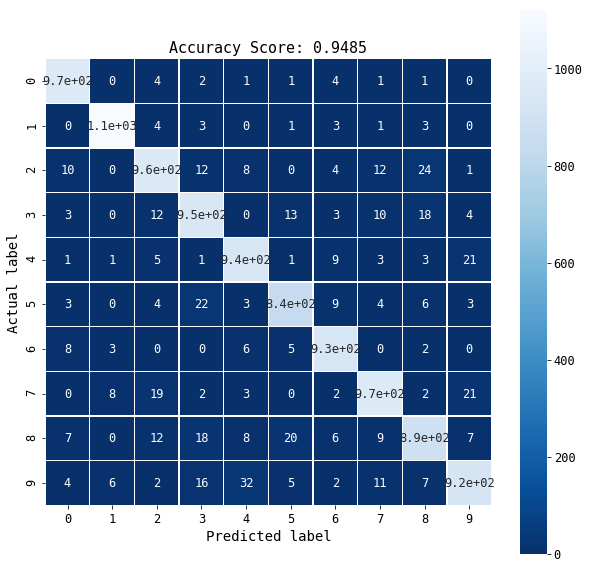

In [11]:
import seaborn as sns
# Using the confusion matrix derived from the RFC, we see below the boosted accuracy of the prediction

plt.figure(figsize=(10,10))
sns.heatmap(cmp, annot=True, linewidths=.25, square = True, cmap = 'Blues_r')
plt.ylabel('Actual label', fontsize=14)
plt.xlabel('Predicted label', fontsize=14)
all_sample_title = 'Accuracy Score: {0}'.format(accp)
plt.title(all_sample_title, size = 15)
# plt.savefig('pca_heatmap.png')
plt.show

## 2) Support Vector Machines

(a) Theory: Explain either the mathematics or the intuition behind the kernel trick used in SVMs and how it allows to express a non-linear classifier through a linear classifier in a higher-dimensional space. 

In [ ]:
# See paper for exlpanation of intuition and mathematics

(b) Practical: Build a linear support vector classifier in Python for the MNIST classification task. Use various kernels to build a better non-linear classifier. 

In [14]:
# Linear Classifier
# Recording time
time_start = time.time() 

# SVM regularization parameter
clf = svm.SVC(kernel='linear')
svc = clf.fit(train_images, train_labels)
predicted = svc.predict(test_images)

print("Classification report for svc %s:\n%s\n"
      % (svc, metrics.classification_report(test_labels, predicted)))

print("Accuracy={}".format(metrics.accuracy_score(test_labels, predicted)))

# time used
time_end = time.time()
print('Time to classify: %0.2f minutes.' % ((time_end-time_start)/60))

Classification report for svc SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='linear', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False):
              precision    recall  f1-score   support

           0       0.95      0.98      0.96       980
           1       0.97      0.99      0.98      1135
           2       0.93      0.94      0.93      1032
           3       0.91      0.94      0.92      1010
           4       0.94      0.96      0.95       982
           5       0.91      0.90      0.91       892
           6       0.96      0.95      0.95       958
           7       0.95      0.93      0.94      1028
           8       0.94      0.90      0.92       974
           9       0.95      0.91      0.93      1009

   micro avg       0.94      0.94      0.94     10000
   macro avg       0.94      0.94      0.94     10000
weighted avg       0.94   

In [ ]:
# # Grid search to find best classifier
# # Generate a much smaller matrix with gammas and make matrix flat
# gamma_range = np.outer(np.logspace(-3, 0, 4),np.array([1,5]))
# gamma_range = gamma_range.flatten()

# # Generate matrix with all C and flatten matrix
# C_range = np.outer(np.logspace(-1, 1, 3),np.array([1,5]))
# C_range = C_range.flatten()

# parameters = {'kernel':['rbf'], 'C':C_range, 'gamma': gamma_range}

# svm_clsf = svm.SVC()
# grid_clsf = GridSearchCV(estimator=svm_clsf,param_grid=parameters,n_jobs=1, verbose=2)
# grid_clsf.fit(train_images, train_labels)
# sorted(grid_clsf.cv_results_.keys())

# classifier = grid_clsf.best_estimator_
# params = grid_clsf.best_params_
# scores = grid_clsf.cv_results_['mean_test_score'].reshape(len(C_range), len(gamma_range))

# plot_param_space_heatmap(scores, C_range, gamma_range)

In [18]:
# Non-Linear Classifier
# Recording time
time_start=time.time() 

# SVM regularization parameters
clf2 = svm.SVC(C = 5, gamma = 0.05)
svc2 = clf2.fit(train_images, train_labels)
predicted2 = svc2.predict(test_images) # predict

print("Classification report for classifier %s:\n%s\n"
      % (svc2, metrics.classification_report(test_labels, predicted2)))

print("Accuracy={}".format(metrics.accuracy_score(test_labels, predicted2)))

# time used
time_end = time.time()
print('Time to classify: %0.2f minutes.' % ((time_end-time_start)/60))

Classification report for classifier SVC(C=5, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.05, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False):
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       980
           1       0.99      0.99      0.99      1135
           2       0.98      0.98      0.98      1032
           3       0.98      0.99      0.98      1010
           4       0.98      0.98      0.98       982
           5       0.99      0.98      0.98       892
           6       0.99      0.99      0.99       958
           7       0.98      0.98      0.98      1028
           8       0.97      0.99      0.98       974
           9       0.98      0.96      0.97      1009

   micro avg       0.98      0.98      0.98     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       0.98      0.98    

## 3) Neural Networks

(a) Theory: By applying the chain law of derivatives to the objective function of a neural network, derive the back propagation algorithm.

In [ ]:
# See paper for derivation of backpropagation algorithm

(b) Coding: Implement from scratch, as a Python class, a feedforward neural network with 1 hidden layer of 100 hidden units merely using basic linear algebra computations in Numpy. Based on your derivation of back-propagation, or otherwise, implement a train method based on stochastic or batch gradient descent. Test your implementation on the MNIST classification task. 

In [7]:
# Re-importing unseparated MNIST data from sklearn to preprocess before training network
mnist = fetch_mldata('MNIST original')
X, y = mnist["data"], mnist["target"]

# Scale
X = np.array(X)/255

# One-hot encode labels to convert categorical numbers to numerical form
digits = 10
shape = y.shape[0]
labels = y.reshape(1, shape)
labels_new = np.eye(digits)[labels.astype('int32')]
labels_new = labels_new.T.reshape(digits, shape)

# Split, reshape, shuffle to allow proper training
m = 60000

train_images, test_images = X[:m].T, X[m:].T
train_labels, test_labels = labels_new[:,:m], labels_new[:,m:]
shuffle_index = np.random.permutation(m)
train_images, train_labels = train_images[:, shuffle_index], train_labels[:, shuffle_index]

/Applications/anaconda3/envs/venv_ml/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function fetch_mldata is deprecated; fetch_mldata was deprecated in version 0.20 and will be removed in version 0.22
  warnings.warn(msg, category=DeprecationWarning)
/Applications/anaconda3/envs/venv_ml/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function mldata_filename is deprecated; mldata_filename was deprecated in version 0.20 and will be removed in version 0.22
  warnings.warn(msg, category=DeprecationWarning)


In [8]:
class NeuralNetwork():
    
    def __init__(self):
        #Setting shape used to determine weights, size of hidden layer and output layer
        self.x_shape = train_images.shape[0]
        self.h_layer = 100
        self.out_layer = 10
        
        #Generating random weights and biases used to train the network with X.shape
        self.W1 = np.random.randn(self.h_layer, self.x_shape) * np.sqrt(1. / self.x_shape)
        self.W2 = np.random.randn(self.out_layer, self.h_layer) * np.sqrt(1. / self.h_layer)
        self.b1 = np.zeros((self.h_layer, 1)) * np.sqrt(1. / self.x_shape)
        self.b2 = np.zeros((self.out_layer, 1)) * np.sqrt(1. / self.h_layer)
        
        #Creating derivatives of weights and biases that will used to improve NN
        #Idea derived from J. Weisberg implementation of NN
        self.V_dW1 = np.zeros(self.W1.shape)
        self.V_dW2 = np.zeros(self.W2.shape)
        self.V_db1 = np.zeros(self.b1.shape)
        self.V_db2 = np.zeros(self.b2.shape)
    
    def sigmoid(self, z):
        s = 1. / (1. + np.exp(-z))
        return s

    def multiLoss(self, Y, Y_hat):
        #As there are different digits to predict, 
        #we define the multiclass loss (logarithmic loss function)
        L_sum = np.sum(np.multiply(Y, np.log(Y_hat)))
        m = Y.shape[1]
        L = -(1./m) * L_sum

        return L

    def feedForward(self, X):
        #Multiplying input by weights and adding bias
        #Cache is used to stores the data and helps NN run faster
        cache = {}

        cache["Z1"] = np.matmul(self.W1, X) + self.b1
        cache["A1"] = self.sigmoid(cache["Z1"])
        cache["Z2"] = np.matmul(self.W2, cache["A1"]) + self.b2
        cache["A2"] = np.exp(cache["Z2"]) / np.sum(np.exp(cache["Z2"]), axis=0)

        return cache

    def backPropagate(self, X, Y, cache):
        #Adjusting the weights using error. Derivatives are obtained using matrix multiplication 
        dZ2 = cache["A2"] - Y
        dW2 = (1./batch) * np.matmul(dZ2, cache["A1"].T)
        db2 = (1./batch) * np.sum(dZ2, axis=1, keepdims=True)

        dA1 = np.matmul(self.W2.T, dZ2)
        dZ1 = dA1 * self.sigmoid(cache["Z1"]) * (1 - self.sigmoid(cache["Z1"]))
        dW1 = (1./batch) * np.matmul(dZ1, X.T)
        db1 = (1./batch) * np.sum(dZ1, axis=1, keepdims=True)

        grads = {'dW1': dW1, 'db1': db1, 'dW2': dW2, 'db2': db2}
        
        #Obtaining a moving average of gradients
        self.V_dW1 = (beta * self.V_dW1 + (1. - beta) * grads['dW1'])
        self.V_dW2 = (beta * self.V_dW2 + (1. - beta) * grads['dW2'])
        self.V_db1 = (beta * self.V_db1 + (1. - beta) * grads['db1'])
        self.V_db2 = (beta * self.V_db2 + (1. - beta) * grads['db2'])
        
        #Adjusting weights
        self.W1 = self.W1 - l_rate * self.V_dW1
        self.W2 = self.W2 - l_rate * self.V_dW2
        self.b1 = self.b1 - l_rate * self.V_db1
        self.b2 = self.b2 - l_rate * self.V_db2

        return grads
    
nn = NeuralNetwork()

In [9]:
# Set hyperparameters used to train network

# Learning rate to control how much we are adjust the weights with respect the loss gradient
l_rate = 1

# At each pass we shuffle the training set, then iterate through it in chunks of batch_size
batch_size = 128
batches = -(-m // batch_size)

# To add momentum, we keep a moving average of our gradients
beta = .9

In [10]:
np.random.seed(128)

# Train network
for i in range(12):
    for j in range(batches):

        start = j * batch_size
        end = min(start + batch_size, train_images.shape[1] - 1)
        X = train_images[:, start:end]
        Y = train_labels[:, start:end]
        batch = end - start

        cache = nn.feedForward(X)
        grads = nn.backPropagate(X, Y, cache)

    cache = nn.feedForward(train_images)
    train_cost = nn.multiLoss(train_labels, cache["A2"])
    cache = nn.feedForward(test_images)
    test_cost = nn.multiLoss(test_labels, cache["A2"])
    print('Epoch {}: Training Cost = {}'.format(i+1 ,train_cost) + '\n',
          'Test Cost = {}'.format(test_cost) + '\n')

print('Done!')

Epoch 1: Training Cost = 0.25462061413265297
 Test Cost = 0.2491632930388917

Epoch 2: Training Cost = 0.18571420730030788
 Test Cost = 0.184774938112123

Epoch 3: Training Cost = 0.1472138383846686
 Test Cost = 0.1500684912372169

Epoch 4: Training Cost = 0.12280474347559155
 Test Cost = 0.12980372700280213

Epoch 5: Training Cost = 0.10529867105018399
 Test Cost = 0.11626889964553865

Epoch 6: Training Cost = 0.09222707815444771
 Test Cost = 0.10673753363601919

Epoch 7: Training Cost = 0.08209628041272898
 Test Cost = 0.09971101295892545

Epoch 8: Training Cost = 0.07390545028196013
 Test Cost = 0.09425678450908265

Epoch 9: Training Cost = 0.06701365577320445
 Test Cost = 0.08981881617254019

Epoch 10: Training Cost = 0.061042152396165915
 Test Cost = 0.08608734737204411

Epoch 11: Training Cost = 0.055782202326984824
 Test Cost = 0.0828945448596816

Epoch 12: Training Cost = 0.0511186453356671
 Test Cost = 0.08014854760405857

Done!


In [11]:
cache = nn.feedForward(test_images)
predict = np.argmax(cache["A2"], axis=0)
targets = np.argmax(test_labels, axis=0)

print(classification_report(predict, targets))

              precision    recall  f1-score   support

           0       0.98      0.98      0.98       985
           1       0.99      0.99      0.99      1133
           2       0.97      0.98      0.98      1015
           3       0.99      0.95      0.97      1046
           4       0.98      0.97      0.97       996
           5       0.96      0.98      0.97       877
           6       0.98      0.98      0.98       963
           7       0.98      0.97      0.97      1035
           8       0.97      0.97      0.97       965
           9       0.96      0.98      0.97       985

   micro avg       0.98      0.98      0.98     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       0.98      0.98      0.98     10000



(c) Practical: Use TensorFlow (potentially using a frontend such as tflearn or keras) to implement a 2 layer neural network with 1200 and 1200 hidden units. Use RELU activation function instead of sigmoids, as well as add regularisation methods such as dropout to produce a model which has a test error of below 2%. 10 points will be given for building a working network and 5 point for achieving the benchmark. 

In [45]:
# Reloading the data from keras, split between train and test sets
from keras.datasets import mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

# Reshape array to have 2 dimensions
train_images = train_images.reshape(60000, 784)
test_images = test_images.reshape(10000, 784)

# Convert to float and scale
train_images = train_images.astype('float32')
test_images = test_images.astype('float32')
train_images /= 255
test_images /= 255

# Converting vectors to binary class matrices
train_labels = keras.utils.to_categorical(train_labels, 10)
test_labels = keras.utils.to_categorical(test_labels, 10)

model = Sequential()

# First layer 784 x 1200 and drop out regulariser to ignore randomly selected neurons
model.add(Dense(1200, activation='relu', input_shape=(784,)))
model.add(Dropout(0.2))

# Second layer 1200 x 1200 and drop out regulariser to ignore randomly selected neurons
model.add(Dense(1200, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(10, activation='softmax'))

model.summary()
model.compile(loss='categorical_crossentropy', optimizer=Adadelta(), metrics=['accuracy'])

history = model.fit(train_images, train_labels, 
                    batch_size=128, epochs=12, verbose=1,
                    validation_data = (test_images, test_labels))
score = model.evaluate(test_images, test_labels, verbose=0)

print('Test loss:', score[0])
print('Test accuracy:', score[1])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_18 (Dense)             (None, 1200)              942000    
_________________________________________________________________
dropout_13 (Dropout)         (None, 1200)              0         
_________________________________________________________________
dense_19 (Dense)             (None, 1200)              1441200   
_________________________________________________________________
dropout_14 (Dropout)         (None, 1200)              0         
_________________________________________________________________
dense_20 (Dense)             (None, 10)                12010     
Total params: 2,395,210
Trainable params: 2,395,210
Non-trainable params: 0
_________________________________________________________________
Train on 60000 samples, validate on 10000 samples
Epoch 1/12
60000/60000 [==============================] - 14s 229us/step - loss: 0

## 4) Data Science Challenge

This is a problem to challenge you. Any reasonable attempt will grant you full points. For this problem (and only for this problem) you are allowed to work in groups of up to 3 students handing in the same solution. The idea is that you use this last problem as a competition between your peers or peer groups in the course. It is a continuation of problem 3.c. Using a high-level frontend for tensorflow such as tflearn or keras, try to improve your classifier by means of deeper networks and/or convolution layers which are readily available as plug&play building blocks. Depending on interest and time we can use the more challenging CIFAR10 data set for this last part as opposed to the simpler to predict MNIST dataset. In the latter case, it would also make sense to use GPUs.

In [23]:
# Reloading the data from keras, split between train and test sets
from keras.datasets import mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

# Reshape array to fit Conv2D model
train_images = train_images.reshape(60000,28,28,1)
test_images = test_images.reshape(10000,28,28,1)

# Convert to float and scale
train_images = train_images.astype('float32')
test_images = test_images.astype('float32')
train_images /= 255
test_images /= 255

# Converting vectors to binary class matrices
train_labels = keras.utils.to_categorical(train_labels, 10)
test_labels = keras.utils.to_categorical(test_labels, 10)

model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(28,28,1)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))

model.summary()
model.compile(loss='categorical_crossentropy', optimizer=Adadelta(), metrics=['accuracy'])

history = model.fit(train_images, train_labels, 
                    batch_size=128, epochs=12, verbose=1,
                    validation_data = (test_images, test_labels))
score = model.evaluate(test_images, test_labels, verbose=0)

print('Test loss:', score[0])
print('Test accuracy:', score[1])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 12, 12, 64)        0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 9216)              0         
_________________________________________________________________
dense_10 (Dense)             (None, 128)               1179776   
_________________________________________________________________
dropout_8 (Dropout)          (None, 128)               0         
__________